In [6]:
import fiona
from shapely.geometry import Polygon, Point, MultiPolygon
us_states = fiona.open('cb_2015_us_state_20m.shp')
states = {}
for state in us_states:
    name = state.get('properties')['NAME']
    poly_type = state.get('geometry').get('type')
    if poly_type == 'Polygon':
        poly = Polygon(state.get('geometry').get('coordinates')[0])
    elif poly_type == 'MultiPolygon':
        # get list of polygons and merge into a MultiPolygon
        polygons = []
        for sub_poly in state.get('geometry').get('coordinates'):
            polygons.append(Polygon(sub_poly[0]))
        poly = MultiPolygon(polygons)
    else:
        print('Unknown polygon type for state: ' + name)
    states[name] = poly

In [2]:
def get_state(point):
    for state_name, state_poly in states.items():
        if state_poly.contains(point):
            return state_name
    return "unknown"

In [3]:
import pyspark
sc = pyspark.SparkContext()

### test with a list of known cities

In [23]:
cities = [
    ('San Antonio', Point(-98.493628, 29.424122)),
    ('Houston', Point(-95.369803, 29.760427)),
    ('Denver', Point(-104.990251, 39.739236)),
    ('Honolulu', Point(-157.858333, 21.306944)),
    ('Raleigh', Point(-78.638179, 35.779590)),
    ('Detroit', Point(-84.045754, 42.331427)),
    ('London', Point(-0.127758, 51.507351)),
    ('Washington', Point(-77.036871, 38.907192)),
    ('San Juan', Point(-66.105735, 18.465539))]
cities_rdd = sc.parallelize(cities)


In [40]:
cities_w_state = cities_rdd.map(lambda line: (line[0], get_state(line[1])))
us_cities = cities_w_state.filter(lambda line: line[1] != 'unknown')
us_cities.take(10)

[('San Antonio', 'Texas'),
 ('Houston', 'Texas'),
 ('Denver', 'Colorado'),
 ('Honolulu', 'Hawaii'),
 ('Raleigh', 'North Carolina'),
 ('Detroit', 'Michigan'),
 ('Washington', 'District of Columbia'),
 ('San Juan', 'Puerto Rico')]

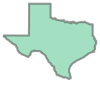

In [37]:
states['Texas']